# Submission Final for San Francisco Crime Classification

## MIDS W207 Final Project

DATASCI W207 Applied Machine Learning, Section 6

This notebook comprises our team's response to the Kaggle challenge "San Francisco Crime Classification." We aim to predict the category of crime using time/location data that the city government has sourced over 12 years, from 2003-2015. 

Our main measure for determining model performance is multi-class log loss (also known as cross entropy). We have developed a pipeline to scale and standardize our workflow - from feature generation to model fit, cross-validation, and result submission - in order to enable all team members to simultaneously test and explore different avenues of opportunity. We have merged most of our code in this notebook directly, but please note there are additional notebooks linked below as well. 

The models we explore include Logistic Regression, KNN, Random Forest, Gradient Boosted Trees, and Multilayer Perceptron (all from Scikit-Learn). 

More on the Kaggle competition: https://www.kaggle.com/c/sf-crime/overview/description

Project members:

* Linda Dong
* Arthur Lima
* Yang Yang Qian



In [1]:
# Import basic standard libraries
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
import inspect
import datetime

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# Use Seaborn for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Use custom data transformers (see below for link to transformer scripts)
%reload_ext autoreload
%autoreload 2
import src.features.build_features as bf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Confusion matrix code
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_figheight(32)
    fig.set_figwidth(32)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Load Data

In [3]:
train_pd = pd.read_csv("../data/raw/train.csv.zip", compression="zip")
test_pd = pd.read_csv("../data/raw/test.csv.zip", compression="zip")
sample_submissions = pd.read_csv("../data/raw/sampleSubmission.csv.zip", compression="zip")

# Exploratory Data Analysis

In [9]:
print(train_pd.shape)
print(test_pd.shape)

(878049, 9)
(884262, 7)


In [113]:
train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [115]:
test_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


In [123]:
train_pd.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


In [124]:
test_pd.head(3)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212


## Data Cleaning
We check for NAs in both test and train datasets, but didn't find any in either set.

In [135]:
print('The test_pd original shape is: '+ str(test_pd.shape))
temp = test_pd.dropna()
print('The test_pd NEW shape is: '+ str(temp.shape))

print('The train_pd original shape is: '+ str(train_pd.shape))
temp = train_pd.dropna()
print('The train_pd NEW shape is: '+ str(temp.shape))

The test_pd original shape is: (884262, 7)
The test_pd NEW shape is: (884262, 7)
The train_pd original shape is: (878049, 9)
The train_pd NEW shape is: (878049, 9)


## Crime Category

* Categorical variable with 39 levels
* What we are trying to predict
* Highest frequency category of crimes is theft, at around 20% of all crime - data is highly skewed.

In [126]:
print('The total number of categories is: ' + str(len(train_pd.Category.unique())))

The total number of categories is: 39


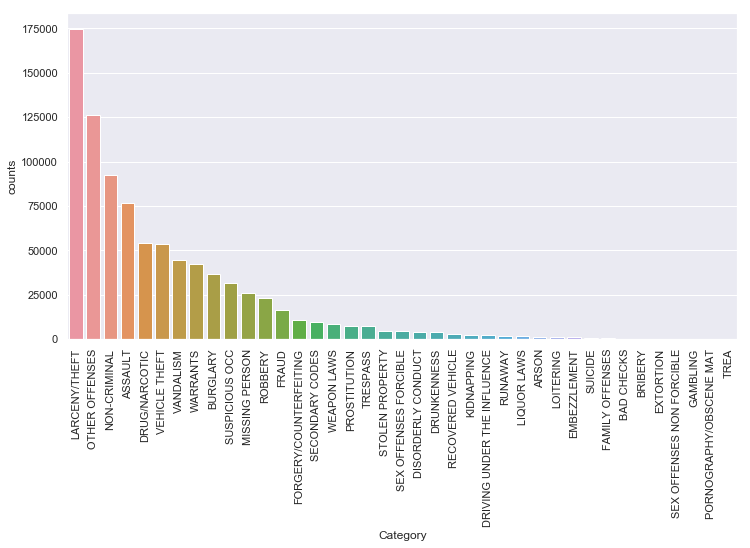

In [127]:
dat = train_pd.groupby(["Category"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "Category", y = "counts", data=dat). \
    set_xticklabels(dat['Category'],rotation = 90)

## PdDistrict

* categorical variable with 10 levels
* probably correlated with X and Y
* southern district appears to have the highest number of reported crimes

Note, since we are measuring reported crimes, rather than actual crimes, it is unclear if this is just a larger district, or has more police resources, or really more crime

In [128]:
print('The total number of PdDistricts is: ' + str(len(train_pd.PdDistrict.unique())))

The total number of PdDistricts is: 10


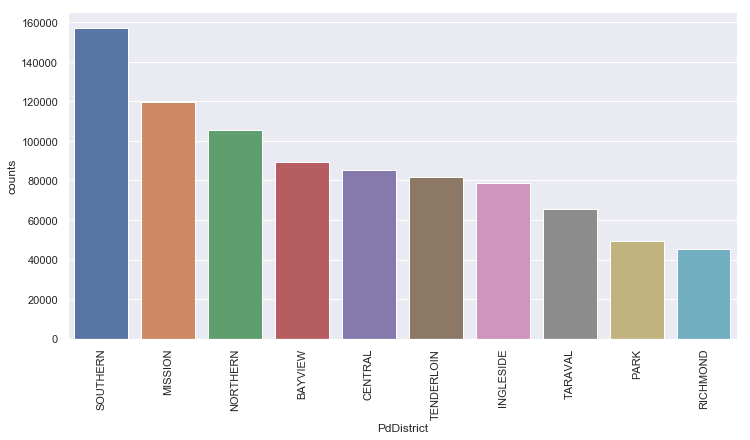

In [129]:
dat = train_pd.groupby(["PdDistrict"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x="PdDistrict", y="counts", data=dat). \
    set_xticklabels(dat['PdDistrict'], rotation = 90)

## Address

* has a combination of street, intersection, and address
* probably correlated with X and Y
* if we treat Address as a categorical variable, we have over 23 thousand levels

Note, some of the addresses with most crime reported does not necessarily mean the crimes happened there. For instance, 800 Block of BRYANT ST is a police station.

In [30]:
print('The total number of unique Addresses is: ' + str(len(train_pd.Address.unique())))

The total number of unique Addresses is: 23228


In [31]:
print('The top Adresses are: ')
print(train_pd.Address.value_counts()[0:5])

The top Adresses are: 
800 Block of BRYANT ST      26533
800 Block of MARKET ST       6581
2000 Block of MISSION ST     5097
1000 Block of POTRERO AV     4063
900 Block of MARKET ST       3251
Name: Address, dtype: int64


## longitude X and latitude Y

* we appeared to have some outliers, maybe some mis-coded locations
* we have outliers in both train and test
* during the training process, we will also be rounding the values
    + we don't need that much precision when estimating

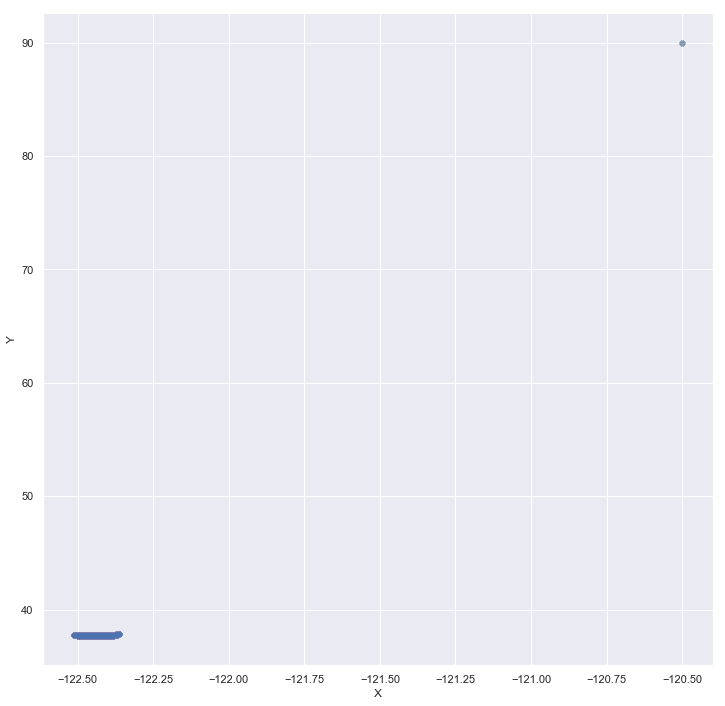

In [8]:
dat = train_pd[["X", "Y"]]
sns.set(rc = {"figure.figsize" : (12, 12)})
ax = sns.scatterplot(x = "X", y = "Y", data = dat, alpha = 0.01)

The latitude of San Francisco, CA, USA is 37.773972, and the longitude is -122.431297. For visualization purposes, we are excluding these records from the data set.

During the training process, any records outside of city limits, will be set to the median of crime inside the city

In [6]:
print(train_pd.query("Y > 50").shape)
print(train_pd.query("X > -122.25").shape)

(67, 9)
(67, 9)


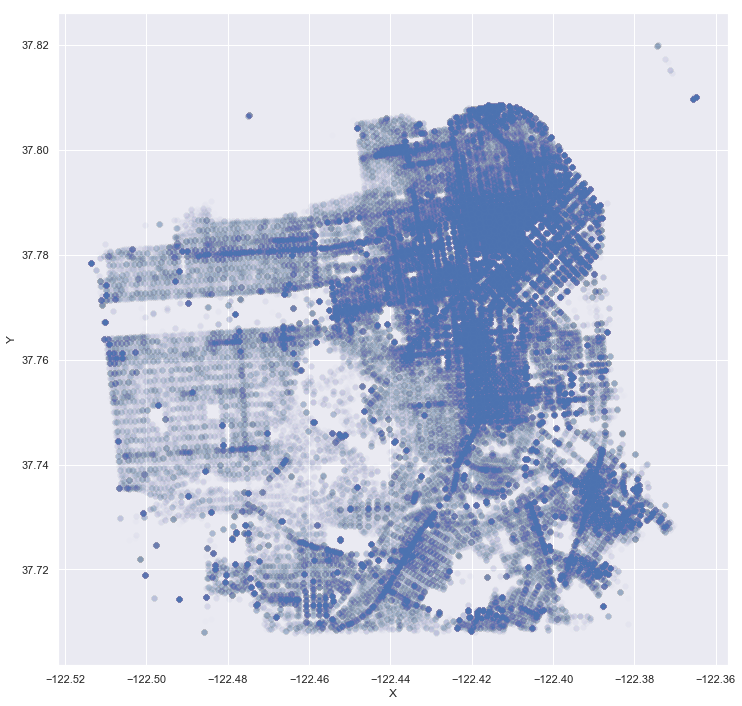

In [7]:
dat = train_pd[["X", "Y"]].query("Y < 50")
sns.set(rc = {"figure.figsize" : (12, 12)})
ax = sns.scatterplot(x = "X", y = "Y", data = dat, alpha = 0.01)

## DayOfWeek

* categorical variable with 7 levels
* looks like number of reported crimes is highest on Friday for some reason
* highest vs lowest is about 12% decrease

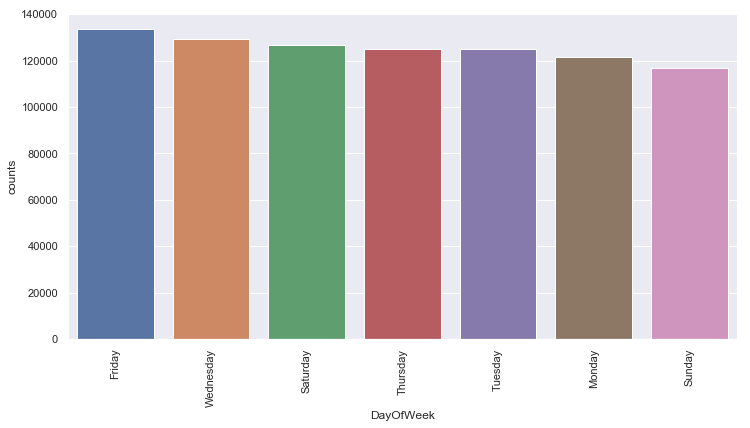

In [9]:
dat = train_pd.groupby(["DayOfWeek"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "DayOfWeek", y = "counts", data=dat).\
    set_xticklabels(dat['DayOfWeek'], rotation = 90)

## Dates

* Dates can be transformed into a variety of features
* can extract various binary features, i.e. is_weekend, is_latenight, is_holiday
* can be treated as categorical, i.e. year
* or can be treated as cyclical continuous, i.e. sin and cos of hour of day

we chose to centralize the code for these transformations in our SFCCTransformer class

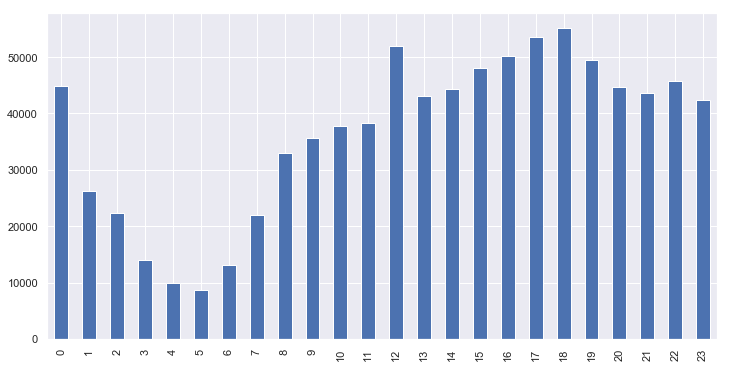

In [46]:
dat = pd.to_datetime(train_pd.Dates).dt.hour
dat = dat.value_counts(sort = False)
dat.plot.bar()

## Resolution and Descript

These features are not in the Test set

* are not useful for prediction, because they are recorded after we know what the crime is

# Feature Engineering and Selection

For feature engineering, we use our custom transformers, SFCCTransformer and SFCCAddressTransformer. 

* many of our features were categorical, so we chose to one-hot-encode them
    + e.g. Address, PdDistrict
* for our Date features
    + some features we extracted various date parts, such as hours and months, and then one-hot-encode them, e.g. day of month
    + some Date features we extracted as binary features, e.g. is_late_night
    + some Date features were cyclical, so we transformed them into sin and cos, e.g. sin of hour, and cos of hour
* for our geographic features, longitude X and latitude Y
    + we chose to impute cases coded outside San Fran as the median
    + we also scaled them to 0 to 1, so that they will be of similar scale to our other features

From the roughly 6 base features in the train and test data, we extracted  over 37 thousand features

For feature selection, we tried both Principal Component Analysis and Random Forest feature importance.

In [15]:
# shuffles the train and test dataframes
train_data, train_labels, dev_data, dev_labels, test_data, test_ids = bf.prep_data(train_pd, test_pd, rs=0, dev_size=0.2)

## PCA

We used PCA to reduce the number of features needed to train on. Objective was to preserve as much of the variance in the data as possible, while projecting down to a lower number of dimensions. 

We plotted the number of components vs the explained variance, and does not look like any of the components dominate in the data. There doesn't seem to be a good "elbow" we can use to justify picking a particular number of components.

Note, we chose to use mostly non-Address related features for PCA. We found that if included Address-based features, we would have had to use TruncatedSVD instead of PCA, because of the size of the resulting sparse matrix.

In [5]:
def extract_features(train_data, dev_data, test_data):
    # sets up the pipelines to transform the data and extract new features
    selector1 = bf.DataFrameSelector(attribute_names = ["X", "Y", "Dates", "DayOfWeek", "PdDistrict"], as_df = True)
    sfcc = bf.SFCCTransformer()
    pipe = Pipeline([
        ("selector1", selector1),
        ("sfcc", sfcc)
    ])
    train_features = pipe.fit_transform(train_data)
    dev_features = pipe.fit_transform(dev_data)
    test_features = pipe.fit_transform(test_data)
    
    return train_features, dev_features, test_features

train_features, dev_features, test_features = extract_features(train_data, dev_data, test_data)

In [6]:
def do_pca(train_features, dev_features, test_features, rs = 0, n_components = None):
    # ingredients for our pipeline
    if n_components is None:
        n_components = train_features.shape[1]
    pca = PCA(n_components = n_components, random_state = rs)
    # sets up the pipelines to transform the data and extract new features
    pipe = Pipeline([
        ("pca", pca)
    ])
    
    # fits our PCA 
    train_pca = pipe.fit_transform(train_features)
    dev_pca = pipe.transform(dev_features)
    test_pca = pipe.transform(test_features)
    return pca, train_pca, dev_pca, test_pca
    
results_pca, train_pca, dev_pca, test_pca = do_pca(train_features, dev_features, test_features, rs = 0, n_components = None)

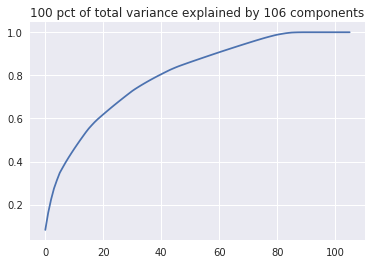

In [46]:
# Analyze explained variance
sns.set(rc = {"figure.figsize" : (6, 4)})
ax = plt.plot(np.arange(0, results_pca.components_.shape[0]), np.cumsum(results_pca.explained_variance_ratio_))
plt.title("%s pct of total variance explained by %s components" % (np.round(results_pca.explained_variance_ratio_.sum() * 100, 0).astype(int) , results_pca.components_.shape[0]))
plt.show()

In [47]:
# Pick number of vectors that explains at least 80%
len(np.where(np.cumsum(results_pca.explained_variance_ratio_) < 0.8)[0])

40

In [8]:
# Rerun PCA with 40
results_pca, train_pca, dev_pca, test_pca = do_pca(train_features, dev_features, test_features, rs = 0, n_components = 40)

# Model Exploration

## PCA with Logistic Regression

Even though LRs work with linear decision boundaries, given the amount of data and LR's tendency not to overfit, we decided to try this with PCA.

In [51]:
from sklearn.linear_model import LogisticRegression

def do_lr(train_data, train_labels, rs = 0):
    log = LogisticRegression(n_jobs=-1, verbose=1)
    pipe = Pipeline([
        ("log", log)
    ])

    param_grid = {
        'log__penalty': ['l1', 'l2'],
        'log__C': [1.0],
    }

    search = GridSearchCV(pipe, param_grid, scoring='neg_log_loss' ,iid = True, cv=2, return_train_score = False, n_jobs=-1)

    _ = search.fit(train_data, train_labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    return search
    
search_lr = do_lr(train_pca, train_labels)

[LibLinear]Best parameter (CV score=-2.569):
{'log__penalty': 'l1', 'log__C': 1.0}


('l1', 2.569273175804867)
('l2', 2.5694139875742077)


Text(0.5,1,u'Train')

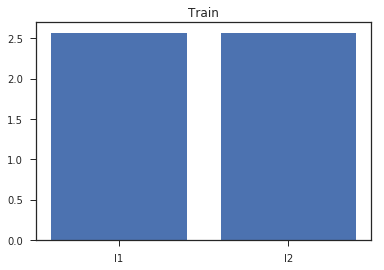

In [54]:
y = search_lr.cv_results_["mean_test_score"]
x = [x['log__penalty'] for x in search_lr.cv_results_["params"]]
for i, j in zip(x, y):
    print(i, -j)
plt.bar(x, -y)
plt.title("Train")

('dev_log_loss', 2.569774406928082)


<Container object of 2 artists>

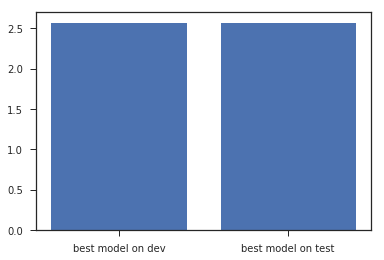

In [62]:
# plot best model on heldout dev performance
from sklearn.metrics import log_loss
predsproba_dev = search_lr.best_estimator_.predict_proba(dev_pca)
dev_results = log_loss(dev_labels, predsproba_dev, labels=np.unique(train_labels))
print("dev_log_loss", dev_results)
plt.bar(["best model on dev", "best model on test"], [dev_results, -y[0]])

In [58]:
predsproba_lr = search_lr.best_estimator_.predict_proba(test_pca)
# converts predicted probabilities into submission panda
submissions_lr = bf.prep_submissions(predsproba_lr, train_pd.Category, test_ids)

print(submissions_lr.shape)
print(submissions_lr.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions_lr.shape[0])
assert(sample_submissions.shape[1] == submissions_lr.shape[1])

(884262, 40)
       Id  ARSON  ASSAULT  BAD CHECKS  BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0  712359    0.0     0.05         0.0      0.0      0.07                 0.0   
1   32865    0.0     0.09         0.0      0.0      0.02                 0.0   
2  536934    0.0     0.11         0.0      0.0      0.03                 0.0   

   DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS  ...  \
0                         0.00           0.06         0.00  ...   
1                         0.01           0.02         0.01  ...   
2                         0.01           0.03         0.01  ...   

   SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY  SUICIDE  SUSPICIOUS OCC  TREA  \
0                        0.0             0.00      0.0            0.03   0.0   
1                        0.0             0.01      0.0            0.03   0.0   
2                        0.0             0.00      0.0            0.03   0.0   

   TRESPASS  VANDALISM  VEHICLE THEFT  WARRANTS  WEAPON LAWS  
0      0.01  

In [61]:
# save submissions to disk
submissions_lr.to_csv("../data/processed/submission_lr.csv.gz", index = False, compression = "gzip")

Confusion matrix, without normalization
[[   0    1    0 ...   21    0    0]
 [   0   12    0 ...  823    0    0]
 [   0    0    0 ...    2    0    0]
 ...
 [   0    6    0 ... 1654    0    0]
 [   0    1    0 ...  323    0    0]
 [   0    0    0 ...   93    0    0]]
This is a beautiful confusion matrix with a lot of confusion.


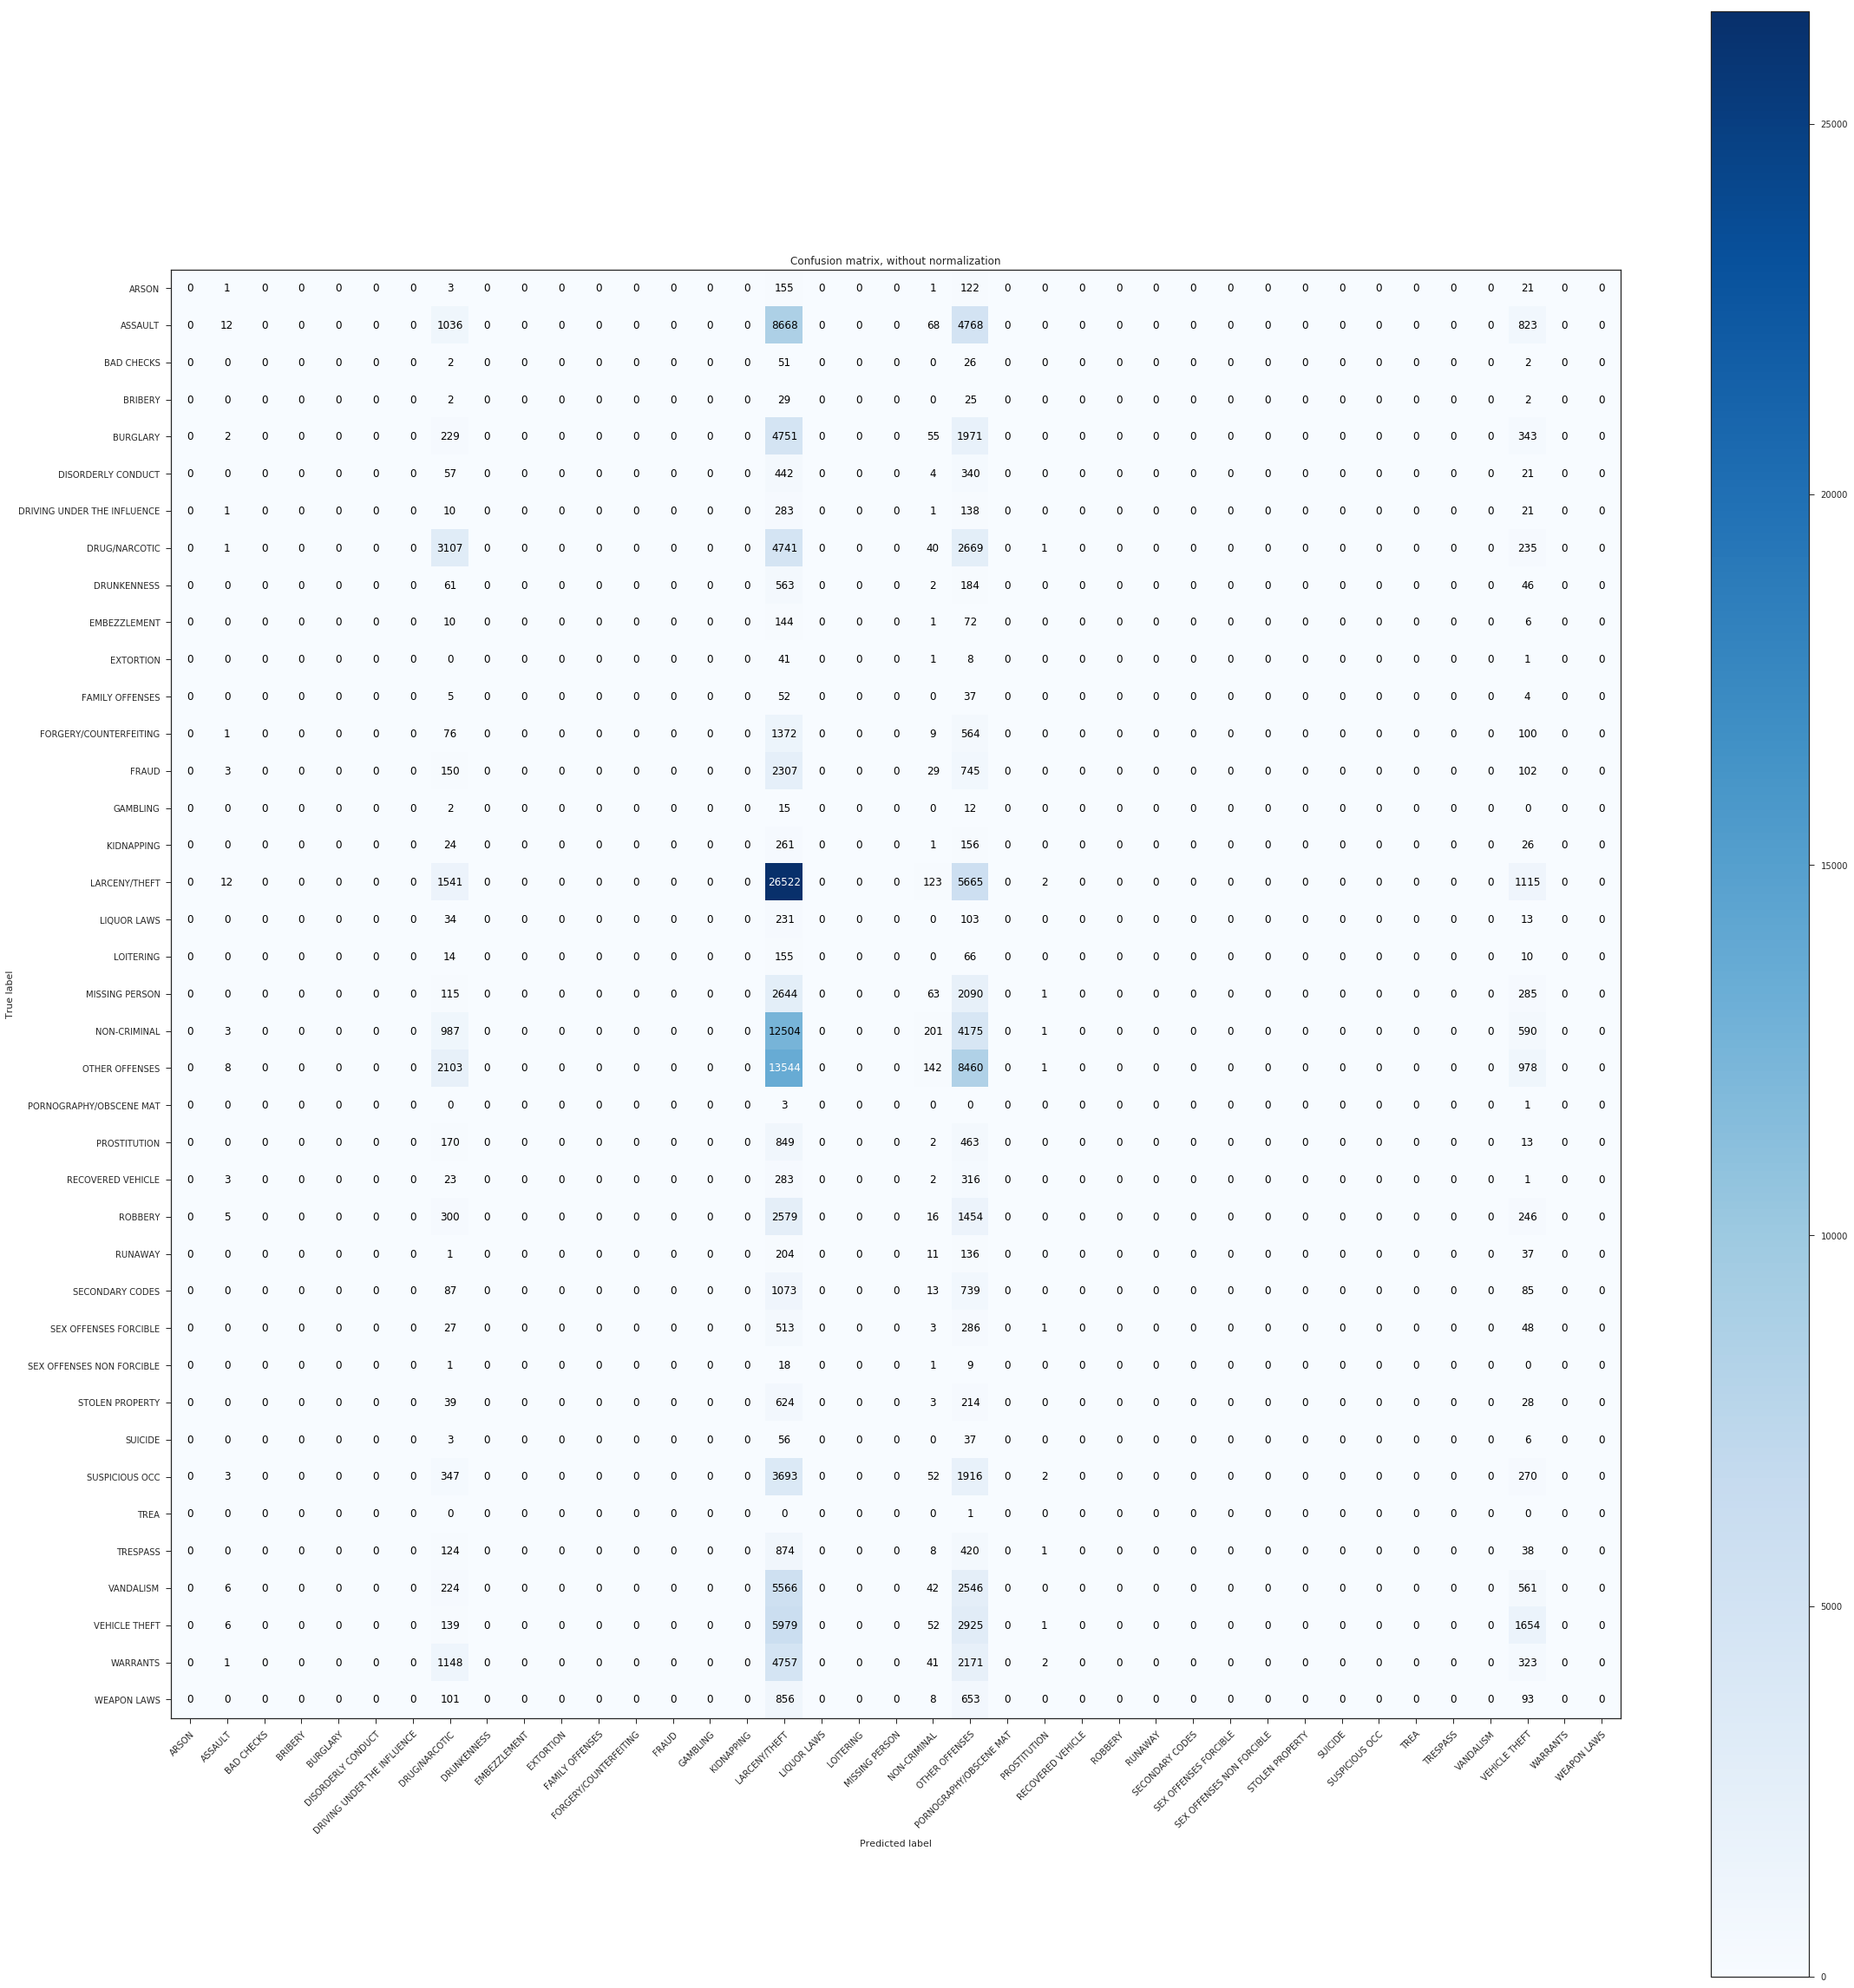

In [65]:
pred_labels = search_lr.best_estimator_.predict(dev_pca)
ax = plot_confusion_matrix(dev_labels, pred_labels, classes=unique_labels(dev_labels, pred_labels))

## Random Forest & Feature Importance

In addition, we also:
* Reduced the full set of features to just those with non-zero importance
* Then using the smaller set of features, trained more random forests classifiers, which we used to predict on the test set

In [12]:
def do_rf_fi(train_data, train_labels, test_data, test_ids, sample_submissions, rs = 0):
    # ingredients for our pipeline
    selector1 = bf.DataFrameSelector(attribute_names = ["X", "Y", "Dates", "DayOfWeek", "PdDistrict", "Address"], as_df = True)
    selector2 = bf.DataFrameSelector(attribute_names = ["Address"], as_df = True)
    sfcc = bf.SFCCTransformer()
    sfcc_addr = bf.SFCCAddressTransformer()
    ohe = OneHotEncoder()
    
    # sets up the pipelines to transform the data and extract new features
    pipe1 = Pipeline([
        ("selector1", selector1)
        ,("sfcc", sfcc)
    ])
    
    pipe2 = Pipeline([
        ("selector2", selector2)
        ,("sfcc_addr", sfcc_addr)
        ,("ohe", ohe)
    ])
    
    pipe3 = FeatureUnion(transformer_list = [
        ("pipe1", pipe1),
        ("pipe2", pipe2)
    ])
    
    # extracts all features from train data
    t1 = pipe1.fit_transform(train_data)
    t2 = pipe2.fit_transform(train_data)
    train_prepared = pipe3.fit_transform(train_data)
    
    # also prepares test data
    test_prepared = pipe3.fit_transform(test_data) # not needed!
    
    # full list of features, by combining the features from pipe1 
    # and the features from the one-hot encoder from pipe2
    p1_features = t1.columns.tolist()
    p2_features = ohe.get_feature_names().tolist()
    all_features = p1_features + p2_features
    
    # fits our random forest classifier, to get feature importance
    rfc = RandomForestClassifier(n_estimators = 10, max_leaf_nodes = 10, n_jobs = None, random_state = rs)
    pipe4 = Pipeline([
        ("rfc", rfc)
    ])
    _ = pipe4.fit(train_prepared, train_labels)
    
    # constructs the feature importance as a dataframe for more analysis
    feature_importances = list(zip(all_features, rfc.feature_importances_))
    feature_importances = pd.DataFrame(feature_importances, columns = ["feature", "importance"])
    
    # filters our train and dev data with our non-zero-importance features
    train_prepared_topfeatures = train_prepared[:, list(feature_importances.query("importance > 0").index)]
    test_prepared_topfeatures = test_prepared[:, list(feature_importances.query("importance > 0").index)]
        
    # we want to feed the new features into a forest classifier and pipeline
    rfc2 = RandomForestClassifier(n_estimators = 10, max_leaf_nodes = 10, n_jobs = None, random_state = rs)
    
    param_grid = {
        "n_estimators" : [10]
        ,"max_leaf_nodes" : [10, 20]
    }
    
    search = GridSearchCV(rfc2, param_grid, scoring = "neg_log_loss", iid = True, cv = 2, return_train_score = True, n_jobs = -1)
    _ = search.fit(train_prepared_topfeatures, train_labels)
    
    # runs the best classifier on test data and saves to disk
    predsproba = search.best_estimator_.predict_proba(test_prepared_topfeatures)
    
    # prepares submission 
    submissions = bf.prep_submissions(predsproba, train_labels, test_ids)

    # checks submission has the correct number of rows and columns
    assert(sample_submissions.shape[0] == submissions.shape[0])
    assert(sample_submissions.shape[1] == submissions.shape[1])
    
    # save submissions to disk
    submissions.to_csv("../data/processed/submission_rf.csv.gz", index = False, compression = "gzip")
    
    return search

res = do_rf_fi(train_data, train_labels, test_data, test_ids, sample_submissions)

best parameters are:
{'n_estimators': 10, 'max_leaf_nodes': 20}


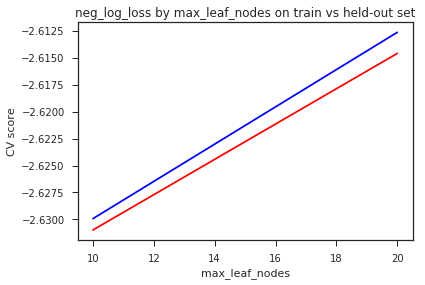

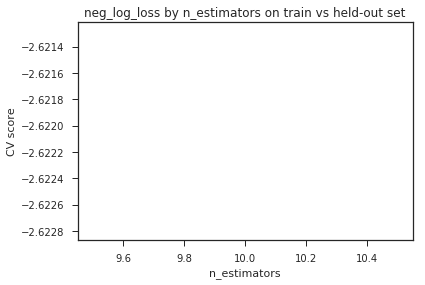

In [13]:
def do_rf_fi_plots(res):
    # best params
    print("best parameters are:")
    print(res.best_params_)
    
    # plots our gscv results
    max_leaf_nodes = [n["max_leaf_nodes"] for n in res.cv_results_["params"]]
    n_estimators = [n["n_estimators"] for n in res.cv_results_["params"]]
    train_scores = res.cv_results_["mean_train_score"]
    test_scores = res.cv_results_["mean_test_score"]
    
    dat = list(zip(max_leaf_nodes, n_estimators, train_scores, test_scores))
    dat = pd.DataFrame(dat, columns = ["max_leaf_nodes", "n_estimators", "train_scores", "test_scores"])
    t1 = dat.groupby("max_leaf_nodes")["train_scores", "test_scores"].mean().reset_index()
    t2 = dat.groupby("n_estimators")["train_scores", "test_scores"].mean().reset_index()
    
    plt.plot(t1.max_leaf_nodes, t1.train_scores, color = "blue")
    plt.plot(t1.max_leaf_nodes, t1.test_scores, color = "red")
    plt.title("neg_log_loss by max_leaf_nodes on train vs held-out set")
    plt.xlabel("max_leaf_nodes")
    plt.ylabel("CV score")
    plt.show()

    plt.plot(t2.n_estimators, t2.train_scores, color = "blue")
    plt.plot(t2.n_estimators, t2.test_scores, color = "red")
    plt.title("neg_log_loss by n_estimators on train vs held-out set")
    plt.xlabel("n_estimators")
    plt.ylabel("CV score")
    plt.show()

do_rf_fi_plots(res)

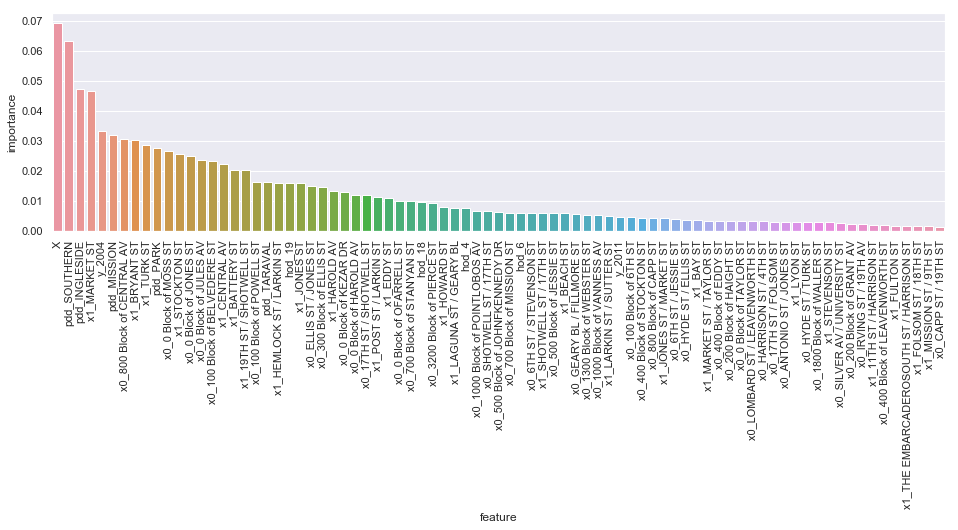

In [40]:
dat = feature_importance.query("importance > 0").sort_values(by = "importance", ascending = False)

sns.set(rc = {"figure.figsize" : (16, 4)})
ax = sns.barplot(x = "feature", y = "importance", data = dat).\
    set_xticklabels(dat['feature'], rotation = 90)

In [42]:
dat = feature_importance.query("importance > 0").sort_values(by = "importance", ascending = False)
print(dat.head())
print(dat.shape)

             feature  importance
0                  X    0.069110
9       pdd_SOUTHERN    0.063227
4      pdd_INGLESIDE    0.047260
31568   x1_MARKET ST    0.046439
82            y_2004    0.033287
(81, 2)


# Other Models



## KNN and PCA

We would like to use PCA with KNN. This didn't quite finish running but we would want to soft-vote this with the LR-PCA above.

In [ ]:
def do_knn(train_data, train_labels, rs = 0):
    knn = KNeighborsClassifier()
    pipe = Pipeline([
        ("knn", knn)
    ])

    param_grid = {
        'knn__n_neighbors': [10],
    }

    search = GridSearchCV(pipe, param_grid, scoring='neg_log_loss' ,iid = True, cv=2, return_train_score = False, n_jobs=-1)

    _ = search.fit(train_data, train_labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    return search
    
search_knn = do_knn(train_pca, train_labels)

# Voting Meta-Model


In [2]:
#read_csv to avg
rf = pd.read_csv("../data/processed/submission_rf.csv.gz")
log = pd.read_csv("../data/processed/submission_lr.csv.gz")
#creating the output dataframe
sub = rf.copy()

#Average out the two data frames
sub = sub.add(log, fill_value=0)
sub = sub/2

#saving new voting DF
sub.to_csv("../data/processed/sub.csv.gz", index = False, compression = "gzip")

## Preparing to Submit to Kaggle

In [ ]:
# converts predicted probabilities into submission panda
submissions = prep_submissions(predsproba, train_pd.Category)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

In [ ]:
# save submissions to disk
submissions.to_csv("../data/processed/submission.csv.gz", index = False, compression = "gzip")

# Appendicies

## More models

We ran some more models on other notebooks, because of computing limitations could not fit into one notebook.

* 1.0-ASL-submission03.1.ipynb
    + https://github.com/ucbiyyq/w207re-final-proj/blob/master/notebooks/1.0-ASL-submission03.ipynb
* 2.0-ld-submission03-mlp-xbt-0419.ipynb
    + https://github.com/ucbiyyq/w207re-final-proj/blob/master/notebooks/2.0-ld-submission03-mlp-xbt-0419.ipynb

## DataFrameSelector

In [56]:
lines = inspect.getsource(bf.DataFrameSelector)
print(lines)

class DataFrameSelector(BaseEstimator, TransformerMixin): 
    """
    Simple helper class, meant make it easier to use Pandas 
    along with sklearn Pipeline. Create and initate with a 
    list of features, then when the pipeline transform function
    is called, will return a Numpy array of the features.
    
    See Chap 2 transformation pipelines
    
    Example:
        train_pd = pd.read_csv("data.csv")
        num_features = ["X", "Y"]
        num_pipeline = Pipeline([
            ("selector", DataFrameSelector(num_features))
        ])
        train_prepared = num_pipeline.transform(train_pd)
        
    """
    def __init__(self, attribute_names = [], as_df = False): 
        self.attribute_names = attribute_names
        self.as_df = as_df
        
    def fit(self, X, y = None): 
        return self 
    
    def transform(self, X): 
        out = X[self.attribute_names].values
        if (self.as_df):    
            out = pd.DataFrame(out, columns = self.attribute_name

## SFCCTransformer

In [57]:
lines = inspect.getsource(bf.SFCCTransformer)
print(lines)

class SFCCTransformer(BaseEstimator, TransformerMixin):
    """
    Helper class for our SanFrancisco Crime Classification project.
    
    Centralizes transformation logic, and make it easier to use
    transformations with Pandas, Pipeline, and gscv. Note, meant to transform
    Pandas into Pandas.
    
    Should use in conjunction with DataFrameSelector and one hot encoders.
    
    See Chap 2 custom transformers
    
    """
    def __init__(self
                 , imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
                 , scaler = MinMaxScaler()
                 , holiday_calendar = USFederalHolidayCalendar()
                 , not_latenight = (7, 20)
                 , geo_fence = (-122.51365, -122.25000, 37.70787, 50.00000)
                 , geo_strategy = "imputer"
                 
                 , pddistrict_drop = True
                 , dayofweek_drop = True
                 , dates_drop = True
                 , address_drop = True
     

## SFCCAddressTransformer

In [58]:
lines = inspect.getsource(bf.SFCCAddressTransformer)
print(lines)

class SFCCAddressTransformer(BaseEstimator, TransformerMixin):
    """
    Helper class for our SanFrancisco Crime Classification project.
    
    note, this transformer does NOT convert the Address features, just prepares it for onehot encoding
    
    Focused on cleaning and transforming Address into various features.
    
    """
    def __init__(self
        , address_drop = False
    ):
        """
        address_drop
                if true, drops the Address feature
                default false
        """
        self.address_drop = address_drop
        
    def fit(self, X, y = None):
        return self # no fitting
    
    def transform(self, X, y = None):
        """
        Creates new features based on Address
        
            1. extracts basic features from Address
            2. converts various streets and intersections
        
        output is one combined dataframe, dense format
        """
        
        # creates a copy of the input dataframe
        X

## Prep Submissions

In [59]:
lines = inspect.getsource(bf.prep_submissions)
print(lines)

def prep_submissions(predsproba, categories, ids):
    """
    Helper function to prepare the raw predsproba array into a panda with the correct column headers and an index
    """
    cols = np.sort(pd.unique(categories))
    submissions = pd.DataFrame(data = predsproba, columns = cols)
    
    # rounds any floats to less precision
    submissions= submissions[cols].round(2)
    
    # adds an Id column
    submissions.insert(loc = 0, column = "Id", value = ids.tolist())
    return(submissions)

